## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
path = '/home/jun/data/MIMIC/processed'
#path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark'
output_path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark/Figure3/'
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

index  subject_id     hadm_id   stay_id               intime  \
0  215414    18566742  27103162.0  38538786  2135-07-16 16:08:00   
1  205452    16853729         NaN  30043998  2178-01-25 05:09:00   
2  200705    16026698         NaN  39475313  2128-10-19 20:01:00   
3   87038    15398519  25237915.0  35495155  2147-06-15 09:50:00   
4  373626    16787687  23674090.0  31087259  2181-03-20 10:38:00   

               outtime  anchor_age gender  anchor_year  dod  \
0  2135-07-17 01:49:00          58      F         2132  NaN   
1  2178-01-25 07:05:00          91      F         2169  NaN   
2  2128-10-19 20:16:00          23      M         2128  NaN   
3  2147-06-15 15:55:00          57      M         2136  NaN   
4  2181-03-21 12:55:00          87      F         2176  NaN   

             admittime            dischtime deathtime               ethnicity  \
0  2135-07-17 00:20:00  2135-07-18 18:20:00       NaN         HISPANIC/LATINO   
1                  NaN                  NaN       NaN                   OTHER   
2                  NaN                  NaN       NaN                     NaN   
3  2147-06-15 14:00:00  2147-06-16 16:45:00       NaN  BLACK/AFRICAN AMERICAN   
4  2181-03-20 22:01:00  2181-03-21 12:55:00       NaN  BLACK/AFRICAN AMERICAN   

             edregtime            edouttime insurance  in_year  age  \
0  2135-07-16 16:08:00  2135-07-17 01:49:00     Other     2135   61   
1                  NaN                  NaN       NaN     2178  100   
2                  NaN                  NaN       NaN     2128   23   
3  2147-06-15 09:50:00  2147-06-15 15:55:00  Medicare     2147   68   
4  2181-03-20 10:38:00  2181-03-21 12:55:00  Medicare     2181   92   

   outcome_inhospital_mortality  ed_death  before_ed_mortality  \
0                         False     False                False   
1                         False     False                False   
2                         False     False                False   
3                         False     False                False   
4                         False     False                False   

            ed_los intime_icu time_to_icu_transfer  outcome_icu_transfer_12h  \
0  0 days 09:41:00        NaN                  NaN                     False   
1  0 days 01:56:00        NaN                  NaN                     False   
2  0 days 00:15:00        NaN                  NaN                     False   
3  0 days 06:05:00        NaN                  NaN                     False   
4  1 days 02:17:00        NaN                  NaN                     False   

   outcome_hospitalization  outcome_critical  n_ed_30d  n_ed_90d  n_ed_365d  \
0                     True             False         0         0          0   
1                    False             False         0         1          7   
2                    False             False         0         0          1   
3                     True             False         0         2          5   
4                     True             False         0         0          2   

    next_ed_visit_time next_ed_visit_time_diff  outcome_ed_revisit_3d  \
0  2136-07-30 17:08:00       379 days 15:19:00                  False   
1  2178-03-11 09:43:00        45 days 02:38:00                  False   
2  2129-01-05 21:12:00        78 days 00:56:00                  False   
3  2147-07-01 10:46:00        15 days 18:51:00                  False   
4  2181-04-06 09:43:00        15 days 20:48:00                  False   

   n_hosp_30d  n_hosp_90d  n_hosp_365d  n_icu_30d  n_icu_90d  n_icu_365d  \
0           0           0            0          0          0           0   
1           0           0            5          0          0           0   
2           0           0            0          0          0           0   
3           0           2            5          0          0           1   
4           0           0            2          0          0           0   

   ed_los_hours  time_to_icu_transfer_hours  next_ed_

In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

age  gender n_ed_30d n_ed_90d n_ed_365d n_hosp_30d n_hosp_90d  \
0  int64  object    int64    int64     int64      int64      int64   

  n_hosp_365d n_icu_30d n_icu_90d n_icu_365d triage_temperature  \
0       int64     int64     int64      int64            float64   

  triage_heartrate triage_resprate triage_o2sat triage_sbp triage_dbp  \
0          float64         float64      float64    float64    float64   

  triage_pain triage_acuity chiefcom_chest_pain chiefcom_abdominal_pain  \
0     float64       float64                bool                    bool   

  chiefcom_headache chiefcom_shortness_of_breath chiefcom_back_pain  \
0              bool                         bool               bool   

  chiefcom_cough chiefcom_nausea_vomiting chiefcom_fever_chills  \
0           bool                     bool                  bool   

  chiefcom_syncope chiefcom_dizziness cci_MI cci_CHF cci_PVD cci_Stroke  \
0             bool               bool  int64   int64   int64      int64   

  cci_Dementia cci_Pulmonary cci_Rheumatic cci_PUD cci_Liver1 cci_DM1 cci_DM2  \
0        int64         int64         int64   int64      int64   int64   int64   

  cci_Paralysis cci_Renal cci_Cancer1 cci_Liver2 cci_Cancer2 cci_HIV  \
0         int64     int64       int64      int64       int64   int64   

  eci_Arrhythmia eci_Valvular eci_PHTN eci_HTN1 eci_HTN2 eci_NeuroOther  \
0          int64        int64    int64    int64    int64          int64   

  eci_Hypothyroid eci_Lymphoma eci_Coagulopathy eci_Obesity eci_WeightLoss  \
0           int64        int64            int64       int64          int64   

  eci_FluidsLytes eci_BloodLoss eci_Anemia eci_Alcohol eci_Drugs  \
0           int64         int64      int64       int64     int64   

  eci_Psychoses eci_Depression  
0         int64          int64

In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.9157284785879691 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.109476566314697 seconds
AUC: 0.80640118511983
AUPRC: 0.7755167714055397
Sensitivity: 0.7537200121469785
Specificity: 0.7101659176588357
Score thresold: 0.44236556806252003
2.5 97.5


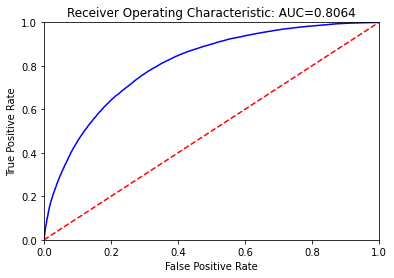

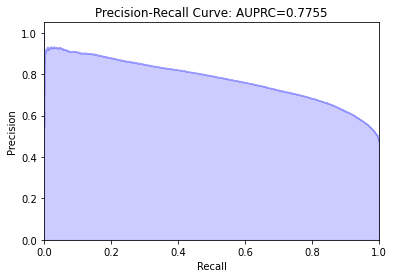

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 324.61675214767456 seconds
AUC: 0.8235740561647393
AUPRC: 0.7991941657451398
Sensitivity: 0.760354131140648
Specificity: 0.7279717151924346
Score thresold: 0.48456061124169447
2.5 97.5


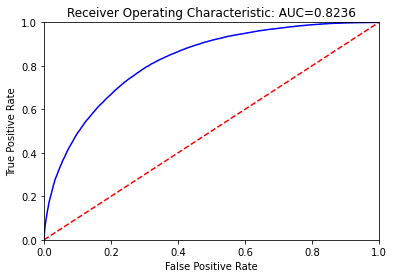

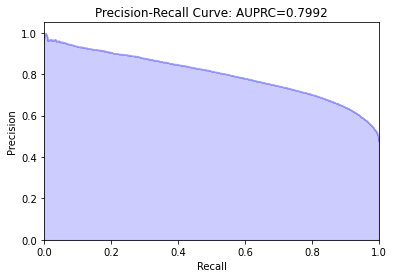

In [12]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=random_seed)
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 61.96535587310791 seconds
AUC: 0.8199760795196774
AUPRC: 0.7866867083312419
Sensitivity: 0.7616389077063235
Specificity: 0.7285041852143724
Score thresold: 0.48309993734335843
2.5 97.5


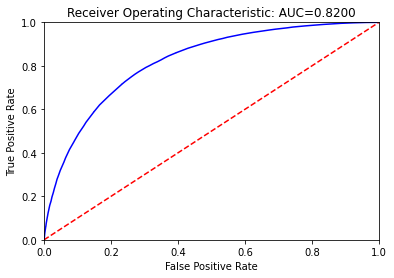

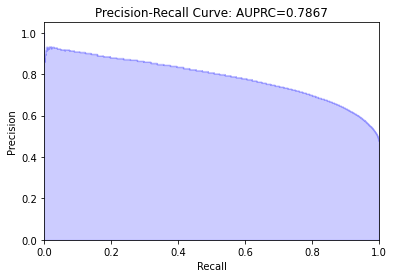

[0.12525509 0.01279777 0.00766098 0.01137398 0.02224353 0.00602808
 0.01541788 0.02688608 0.00078373 0.00185177 0.00497374 0.07775204
 0.0842498  0.04024836 0.0463688  0.08575463 0.08167586 0.04932037
 0.11509131 0.00689224 0.00878755 0.00493709 0.00054284 0.00418723
 0.00280354 0.00379443 0.00428937 0.00341067 0.00408714 0.00336836
 0.00594754 0.00295563 0.00298815 0.00142995 0.00619124 0.00216675
 0.00148706 0.00384988 0.00578306 0.00339048 0.00122948 0.00508669
 0.00439887 0.0014415  0.00200754 0.0010678  0.00842417 0.00274166
 0.00245186 0.00480965 0.01026499 0.00448557 0.0043118  0.00095406
 0.0036834  0.004782   0.00337971 0.01139889 0.00114589 0.00333342
 0.0047185  0.00428578 0.00277225 0.00780051]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 63.79639458656311 seconds
AUC: 0.8201969954347942
AUPRC: 0.7957131364850815
Sensitivity: 0.7389801210025929
Specificity: 0.7435837362356499
Score thresold: 0.4940206167731962
2.5 97.5


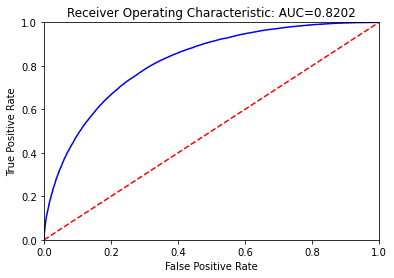

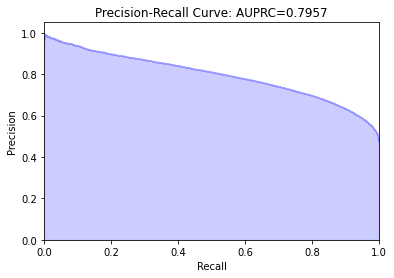

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [16]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7122183722345881
AUPRC: 0.6340355405931188
Sensitivity: 0.5952720222383143
Specificity: 0.774914272326468
Score thresold: -2.6248987751080204
2.5 97.5


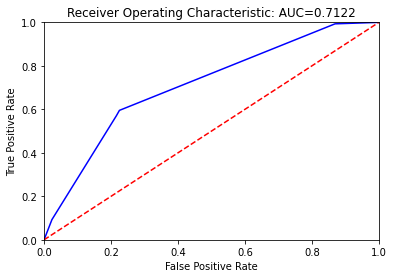

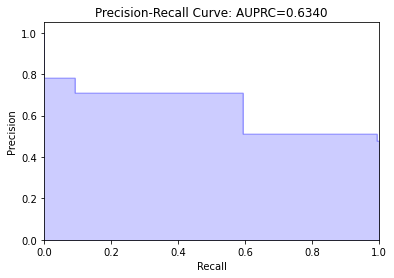

In [17]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

score_NEWS
AUC: 0.5743951007088118
AUPRC: 0.5551390217473994
Sensitivity: 0.5493237403349763
Specificity: 0.5455900832783114
Score thresold: 1
2.5 97.5


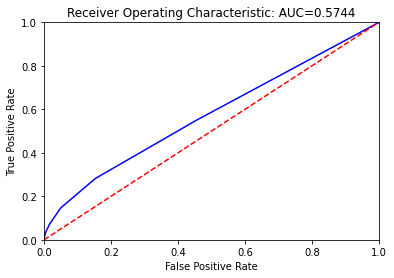

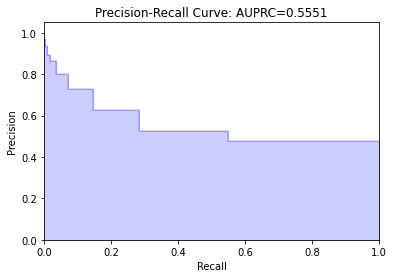

In [18]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5567351357051066
AUPRC: 0.5382689853343715
Sensitivity: 0.502791469083604
Specificity: 0.5680816170049626
Score thresold: 1
2.5 97.5


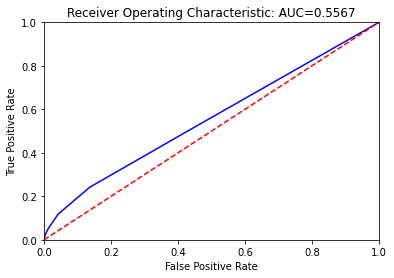

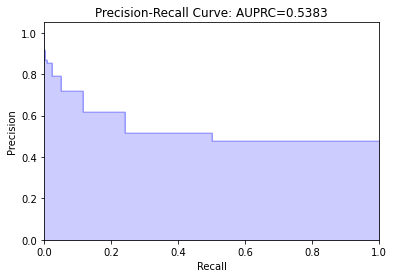

In [19]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6715001298214877
AUPRC: 0.6122906627833825
Sensitivity: 0.7118596556798804
Specificity: 0.5650997848821111
Score thresold: 3
2.5 97.5


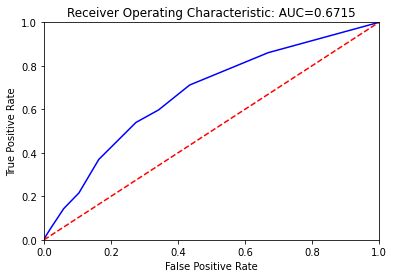

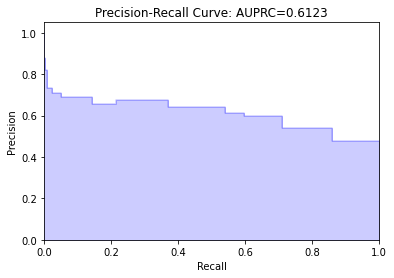

In [20]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5573054456894385
AUPRC: 0.5246811307761181
Sensitivity: 0.290242705973043
Specificity: 0.8138271815296798
Score thresold: 2
2.5 97.5


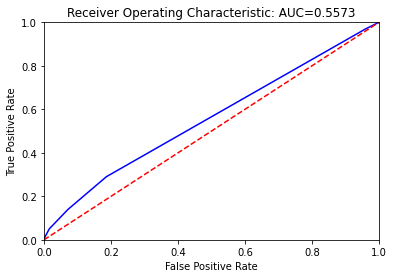

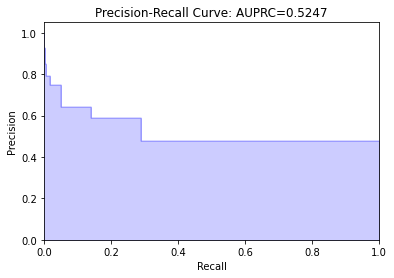

In [21]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6740959981091517
AUPRC: 0.6199567036795708
Sensitivity: 0.6985914176925413
Specificity: 0.589827692700901
Score thresold: 4
2.5 97.5


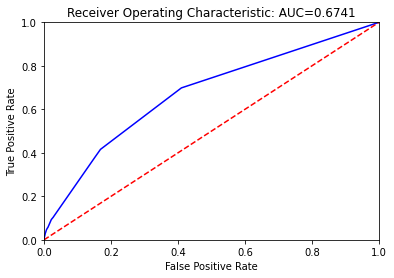

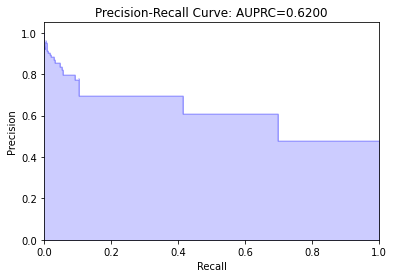

In [22]:
get_score_performance("score_CART", random_seed=random_seed)

In [23]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model

from embedding import *

In [24]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


2021-12-22 15:56:12.829070: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 15:56:13.643253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21865 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2021-12-22 15:56:13.644197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21881 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['tf.math.reduce_su

2021-12-22 15:56:15.640668: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Training time: 1123.3808424472809 seconds


2021-12-22 16:14:57.544898: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: embedding_hospitalization_v10/assets
AUC: 0.8120284873723015
AUPRC: 0.782497390609463
Sensitivity: 0.7480669952580065
Specificity: 0.721603373730059
Score thresold: 0.42803258
2.5 97.5


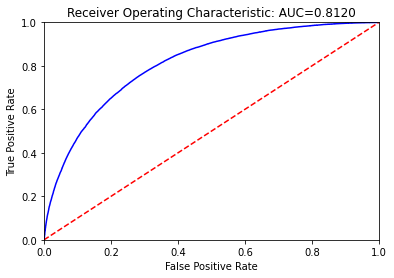

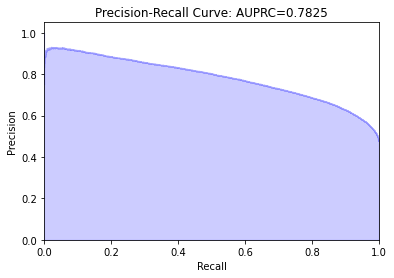

In [25]:
load_model = "embedding_hospitalization_"+version # To train from scratch, set load_model to None
save_model = "embedding_hospitalization_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1123.381
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [26]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df

Model     auroc        ap  sensitivity  specificity  threshold  \
0            LR  0.806401  0.775517     0.753720     0.710166   0.442366   
1           MLP  0.823574  0.799194     0.760354     0.727972   0.484561   
2            RF  0.819976  0.786687     0.761639     0.728504   0.483100   
3            GB  0.820197  0.795713     0.738980     0.743584   0.494021   
4           esi  0.712218  0.634036     0.595272     0.774914  -2.624899   
5    score_NEWS  0.574395  0.555139     0.549324     0.545590   1.000000   
6   score_NEWS2  0.556735  0.538269     0.502791     0.568082   1.000000   
7    score_REMS  0.671500  0.612291     0.711860     0.565100   3.000000   
8    score_MEWS  0.557305  0.524681     0.290243     0.813827   2.000000   
9    score_CART  0.674096  0.619957     0.698591     0.589828   4.000000   
10      Med2Vec  0.812028  0.782497     0.748067     0.721603   0.428033   

    lower_auroc  upper_auroc  std_auroc  lower_ap  upper_ap    std_ap  \
0      0.804388     0.807980   0.000991  0.772588  0.778631  0.001688   
1      0.821958     0.824784   0.000905  0.797186  0.802236  0.001470   
2      0.818365     0.821059   0.000847  0.784114  0.789373  0.001483   
3      0.818477     0.821954   0.001084  0.793039  0.799107  0.001783   
4      0.709660     0.714461   0.001262  0.632307  0.637438  0.001399   
5      0.572413     0.577624   0.001588  0.553995  0.558706  0.001479   
6      0.554930     0.559519   0.001340  0.537061  0.542473  0.001436   
7      0.668802     0.675026   0.001756  0.608725  0.616714  0.002191   
8      0.555632     0.560125   0.001283  0.523748  0.528508  0.001534   
9      0.672075     0.676352   0.001282  0.618035  0.623847  0.001692   
10     0.809722     0.813196   0.001021  0.779251  0.785894  0.001859   

    lower_sensitivity  upper_sensitivity  std_sensitivity  lower_specificity  \
0            0.735099           0.757584         0.006892           0.705992   
1            0.740164           0.767722         0.009512           0.722080   
2            0.744077           0.762986         0.006621           0.725489   
3            0.735893           0.767925         0.009875           0.717475   
4            0.592664           0.599068         0.002093           0.771409   
5            0.544852           0.553164         0.002342           0.543540   
6            0.499457           0.505561         0.001904           0.566327   
7            0.707910           0.716805         0.002180           0.562294   
8            0.286595           0.294159         0.002192           0.811788   
9            0.695179           0.703224         0.002234           0.587627   
10           0.735488           0.751968         0.004114           0.716334   

    upper_specificity  std_specificity      runtime  
0            0.728538         0.006961     5.109477  
1            0.746769         0.008822   324.616752  
2            0.744649         0.006091    61.965356  
3            0.745151         0.008839    63.796395  
4            0.776909         0.001895     0.000000  
5            0.551187         0.002046     0.000000  
6            0.573341         0.001855     0.000000  
7            0.568660         0.001675     0.000000  
8            0.818567         0.001863     0.000000  
9            0.593828         0.001786     0.000000  
10           0.733889         0.004538  1123.380842

FileNotFoundError: [Errno 2] No such file or directory: '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark/Figure3/AUROC_hosp.eps'

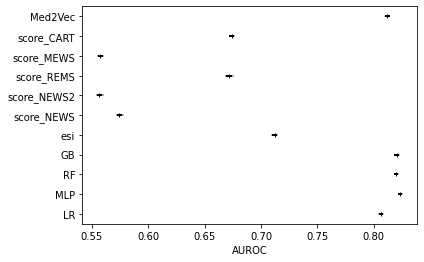

In [27]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path) 

FileNotFoundError: [Errno 2] No such file or directory: 'my_path/AUROC_hosp.eps'

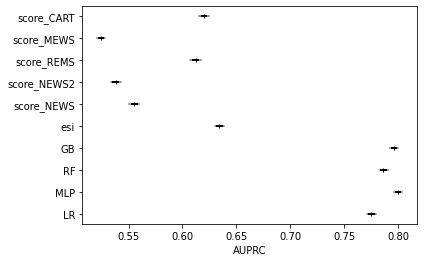

In [ ]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC" )
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [ ]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)